In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from plot_ensemble import ensemble, ensemble_byrcp
import significance_detection_v4 as sd

In [4]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

# Article Figures
This notebook contains figures used in the manuscript, except for the plots from the logistic regression classifier.

## Plot ensemble
Plot the entire ensemble projections (30-year moving average) for both objectives

In [5]:
def plot_ensemble():
    """Ensemble subplots for water supply reliability (SOD) and upstream
    flood volume and add scatterplot for observations"""

    df_rel = ensemble('Rel_SOD_%')
    df_flood = ensemble('Upstream_Flood_Volume_taf')
    # find historical range (max/min)
    rel_min = df_rel['1981-10-1':'2000-10-1'].min().min()
    rel_max = df_rel['1981-10-1':'2000-10-1'].max().max()
    flood_min = df_flood['1981-10-1':'2000-10-1'].min().min()
    flood_max = df_flood['1981-10-1':'2000-10-1'].max().max()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[11, 4])

    # add scatterplot of observed values (20-year average)
    obs = pd.read_csv('obj_historical.csv', index_col=0, parse_dates=True)
    obs.loc['2020-10-1', :] = obs.loc['2000-10-1':'2020-10-1'].mean(axis=0)
    obs['datetime'] = obs.index

    axes[0].plot(obs.loc['2020-10-1', 'datetime'], obs.loc['2020-10-1', 'Rel_SOD_%'], c='red', marker='o',
                 markerfacecolor='red', markersize=5)
    axes[1].plot(obs.loc['2020-10-1', 'datetime'], obs.loc['2020-10-1', 'Upstream_Flood_Volume_taf'],
                 c='red', marker='o', markerfacecolor='red', markersize=5)

    # plot projections
    df_rel['2000-10-1':'2098-10-1'].plot(legend=False, c='lightgray', ax=axes[0], zorder=0)
    df_flood['2000-10-1':'2098-10-1'].plot(legend=False, c='lightgray', ax=axes[1], zorder=0)

    # plot mean
    df_rel.loc['2000-10-1':'2098-10-1', 'mean'].plot(c='steelblue', ax=axes[0], zorder=10)
    df_flood.loc['2000-10-1':'2098-10-1', 'mean'].plot(c='steelblue', ax=axes[1], zorder=10)

    # plot historical ranges
    axes[0].fill_between(df_rel['2000-10-1':'2098-10-1'].index, rel_min, rel_max,
                         facecolor='green', alpha=0.2, zorder=5)
    axes[1].fill_between(df_flood['2000-10-1':'2098-10-1'].index, flood_min, flood_max,
                         facecolor='green', alpha=0.2, zorder=5)

    axes[0].set_ylabel('reliability', size='x-large')
    axes[0].set_title('Water supply reliability projections, 30 yr MA', size='x-large')
    axes[1].set_ylabel('flood volume (TAF)', size='x-large')
    axes[1].set_title('Upstream flood volume projections, 30 yr MA', size='x-large')

    # create custom legend
    legend_elements = [Line2D([0], [0], color='lightgray', label='projections'),
                       Line2D([0], [0], color='steelblue', label='projections mean'),
                       Patch(facecolor='green', alpha=0.5, label='historical range'),
                       Line2D([0], [0], marker='o', color='w', label='observed value (20-yr avg)',
                              markerfacecolor='red', markersize=5)]
    axes[0].legend(handles=legend_elements)
    axes[1].legend(handles=legend_elements)

    plt.tight_layout()
    plt.savefig('significance_results/article_figures/ensemble_plot.png', dpi=300)
    plt.show()
    plt.clf()

    return

Reading data: 100%|██████████| 31/31 [00:11<00:00,  2.66it/s]


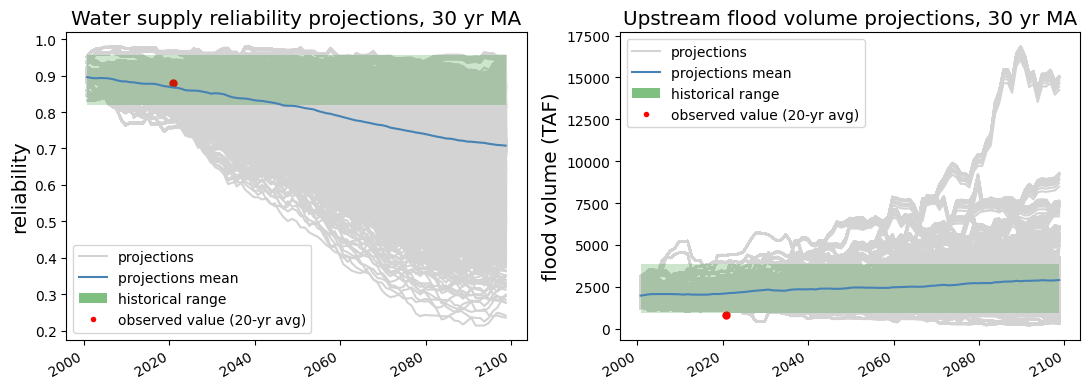

<Figure size 640x480 with 0 Axes>

In [6]:
plot_ensemble()

## Plot rcp objectives
Plot mean objectives (30-year MA) sorted by RCP and +/- standard deviation

In [11]:
def plot_rcp_objective():
    """Plot mean objective (30-year moving averages) +/- 1SD for each RCP"""

    # Get objective data, seperated by RCP
    rel_list = ensemble_byrcp('Rel_SOD_%')
    flood_list = ensemble_byrcp('Upstream_Flood_Volume_taf')

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10, 4])

    # Plot mean water supply reliability and flooding (fill in +/-1 sd)
    rcp_list = ['rcp26', 'rcp45', 'rcp60', 'rcp85']
    color_list = ['blue', 'orange', 'green', 'red']

    for i in range(len(rcp_list)):
        mean_rel = rel_list[i].mean(axis=1)
        sd_rel = rel_list[i].std(axis=1)
        mean_flood = flood_list[i].mean(axis=1)
        sd_flood = flood_list[i].std(axis=1)

        axes[0].plot(rel_list[i].index, mean_rel, color=color_list[i], label='mean - ' + rcp_list[i])
        axes[0].fill_between(rel_list[i].index, mean_rel - sd_rel, mean_rel + sd_rel, facecolor=color_list[i], alpha=0.1)

        axes[1].plot(flood_list[i].index, mean_flood, color=color_list[i], label='mean - ' + rcp_list[i])
        axes[1].fill_between(flood_list[i].index, mean_flood - sd_flood, mean_flood + sd_flood, facecolor=color_list[i], alpha=0.1)

    # Set axis labels and title; add legend
    axes[0].set_ylabel('reliability', size='x-large')
    axes[0].set_xlabel('datetime', size='x-large')
    axes[0].set_title('Water supply reliability by RCP', size='x-large')
    axes[1].set_ylabel('flood volume (TAF)', size='x-large')
    axes[1].set_xlabel('datetime', size='x-large')
    axes[1].set_title('Upstream flood volume by RCP', size='x-large')

    axes[0].legend(loc='lower left')

    plt.tight_layout()
    plt.savefig('significance_results/article_figures/objective_byrcp_plot.png', dpi=300)
    plt.show()
    plt.clf()
    
    return

Reading data: 100%|██████████| 31/31 [00:07<00:00,  4.34it/s]


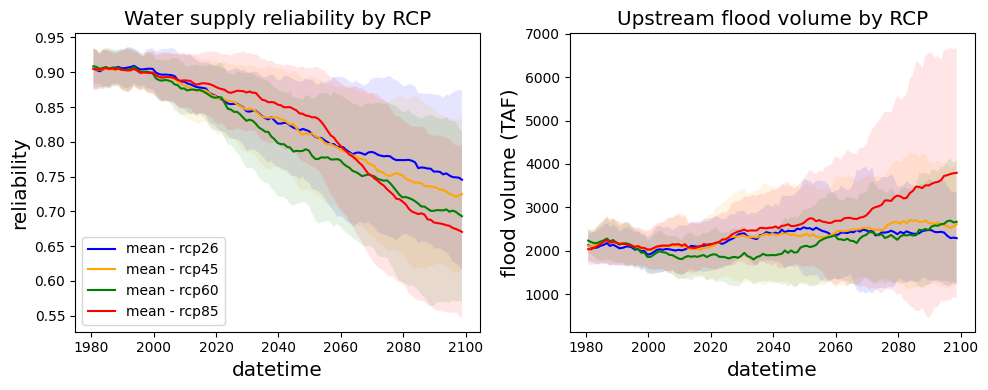

<Figure size 640x480 with 0 Axes>

In [12]:
plot_rcp_objective()

## Plot p-values (FIXME: in progress)
Plot the series of p-values from the sliding window MWU tests for both objectives. Distinguish between scenarios that showed a detection and those that did not (select 25 randomly from each category)

### 1. No pre-whitening

In [ ]:
def pvals_filter(win_size=50, pre_whitening=False):
    """plot p-vals of scenarios. distinguish between scenarios that showed a detection and did not (25 randomly selected from each)"""

    # import pvals, delete values before year 2000 (historical)
    rel_p_vals = pd.read_csv('significance_results/nonparametric/' + 'Rel_SOD_%' + '/' + str(win_size) +
                             '_year_MA/' + 'less' + '_pvals_win' + str(win_size) + '.csv', index_col=0,
                             parse_dates=True).drop(['count', 'rel_count'], axis=1)
    flood_p_vals = pd.read_csv('significance_results/nonparametric/' + 'Upstream_Flood_Volume_taf' + '/' + str(win_size)
                               + '_year_MA/' + 'greater' + '_pvals_win' + str(win_size) + '.csv', index_col=0,
                               parse_dates=True).drop(['count', 'rel_count'], axis=1)
    rel_p_vals = rel_p_vals['2000-10-1':'2098-10-1']
    flood_p_vals = flood_p_vals['2000-10-1':'2098-10-1']

    # randomly select 25 scenarios with detection
    rel_no_detect_names = pd.read_csv('significance_results/nonparametric/Rel_SOD_%/additional_materials/no_detect_'
                                      'scenarios_less_single_win30.csv',
                                      index_col=0).sample(n=25, axis=0, random_state=0)['Model'].tolist()
    flood_no_detect_names = pd.read_csv('significance_results/nonparametric/Upstream_Flood_Volume_taf/'
                                        'additional_materials/no_detect_scenarios_greater_single_win30.csv',
                                        index_col=0).sample(n=25, axis=0, random_state=0)['Model'].tolist()
    rel_p_vals_no_detect = rel_p_vals[rel_no_detect_names]
    flood_p_vals_no_detect = flood_p_vals[flood_no_detect_names]

    # randomly select 25 scemarios without detection
    rel_p_vals_detect = rel_p_vals.drop(rel_no_detect_names, axis=1).sample(n=25, axis=1, random_state=0)
    flood_p_vals_detect = flood_p_vals.drop(flood_no_detect_names, axis=1).sample(n=25, axis=1, random_state=0)

    # plot pvals
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10, 5], sharey=True)
    rel_p_vals_detect.plot(ax=axes[0], c='wheat', legend=False)
    rel_p_vals_no_detect.plot(ax=axes[0], c='lightgray', legend=False)
    axes[0].set_ylabel('p-value', size='x-large')
    axes[0].set_xlabel('datetime', size='x-large')
    axes[0].set_title('Water supply reliability', size='x-large')

    flood_p_vals_detect.plot(ax=axes[1], c='wheat', legend=False)
    flood_p_vals_no_detect.plot(ax=axes[1], c='lightgray', legend=False)
    axes[1].set_title('Upstream flood volume', size='x-large')
    axes[1].set_xlabel('datetime', size='x-large')
    # plot p=0.05
    axes[0].axhline(y=0.05, color='r')
    axes[1].axhline(y=0.05, color='r')

    # create custom legend
    legend_elements = [Line2D([0], [0], color='wheat', label='scenarios with detection'),
                       Line2D([0], [0], color='lightgray', label='scenarios without detection'),
                       Line2D([0], [0], color='red', label='p=0.05'),
                       ]
    axes[1].legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.savefig('significance_results/article_figures/p_vals_win' + str(win_size) + '_filtered.png', dpi=300)
    plt.clf()

    return

## Plot distribution of first detection years
### 1. No pre-whitening

In [1]:
def plot_single_total(win_size=30, pre_whitening=False):
    """Plot distribution for first detection years for water supply reliability (SOD) and upstream flood volume"""

    # Load first detection years from csv's
    if pre_whitening:
        filename_rel = f'significance_results/nonparametric/Rel_SOD_%/{str(win_size)}_year_MA/less_single_total_win{str(win_size)}_pw.csv'
        filenmae_flood = f'significance_results/nonparametric/Upstream_Flood_Volume_taf/{str(win_size)}_year_MA/greater_single_total_win{str(win_size)}_pw.csv'
    else:
        filename_rel = f'significance_results/nonparametric/Rel_SOD_%/{str(win_size)}_year_MA/less_single_total_win{str(win_size)}.csv'
        filenmae_flood = f'significance_results/nonparametric/Upstream_Flood_Volume_taf/{str(win_size)}_year_MA/greater_single_total_win{str(win_size)}.csv'

    years_rel = pd.read_csv(filename_rel, index_col=0)['Year']
    years_flood = pd.read_csv(filenmae_flood, index_col=0)['Year']

    # create subpolots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10, 4], sharey=True)
    years_rel.plot.hist(bins=20, legend=False, ax=axes[0])
    years_flood.plot.hist(bins=20, legend=False, ax=axes[1])
    axes[0].set_xlabel('detection year')
    axes[0].set_title('First detection years for water supply reliability')
    axes[1].set_xlabel('detection year')
    axes[1].set_title('First detection years for upstream flood volume')

    ## export results
    plt.tight_layout()
    if pre_whitening:
        save_dir = 'significance_results/article_figures/first_detection_years_pw.png'
    else:
        save_dir = 'significance_results/article_figures/first_detection_years.png'

    plt.savefig(save_dir)
    plt.show()
    plt.clf()
    
    return

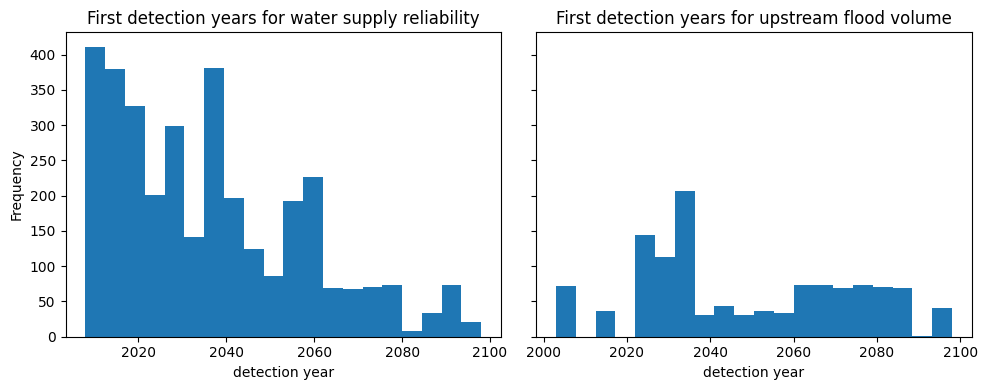

<Figure size 640x480 with 0 Axes>

In [7]:
plot_single_total()

### 2. With pre-whitening

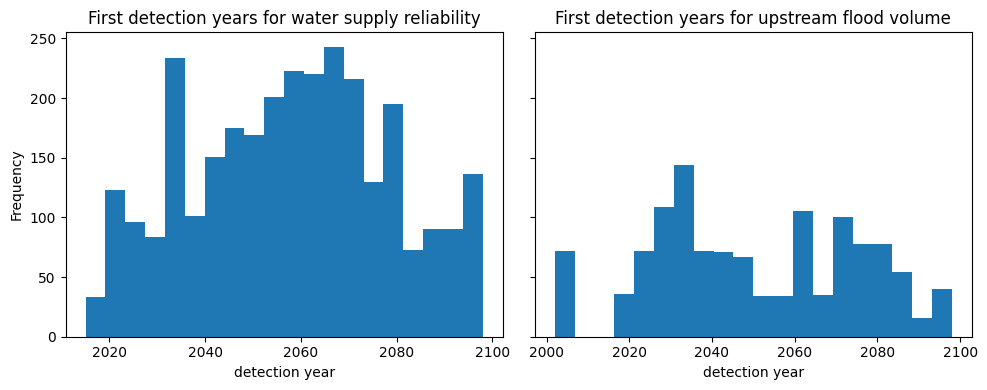

<Figure size 640x480 with 0 Axes>

In [8]:
plot_single_total(pre_whitening=True)

## Plot detection rates

### 1. No pre-whitening

In [9]:
def plot_multi_total(win_size=30, pre_whitening=False):
    """Plot detection rates for water supply reliability (SOD) and upstream flood volume"""

    # Load p-val data (rel counts is included as a column)
    if pre_whitening:
        filename_rel = f'significance_results/nonparametric/Rel_SOD_%/{str(win_size)}_year_MA/less_pvals_win30_pw.csv'
        filename_flood = f'significance_results/nonparametric/Upstream_Flood_Volume_taf/{str(win_size)}_year_MA/greater_pvals_win30_pw.csv'
    else:
        filename_rel = f'significance_results/nonparametric/Rel_SOD_%/{str(win_size)}_year_MA/less_pvals_win30.csv'
        filename_flood = f'significance_results/nonparametric/Upstream_Flood_Volume_taf/{str(win_size)}_year_MA/greater_pvals_win30.csv'

    agg_all_rel = pd.read_csv(filename_rel, index_col=0, parse_dates=True)
    agg_all_flood = pd.read_csv(filename_flood, index_col=0, parse_dates=True)

    # Plot total relative counts
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=[10, 4.5])
    agg_all_rel.loc['2000-10-1':'2098-10-1', 'rel_count'].plot(ax=axes[0])
    agg_all_flood.loc['2000-10-1':'2098-10-1', 'rel_count'].plot(ax=axes[1])

    axes[0].set_ylabel('detection rate', size='x-large')
    axes[0].set_title('Water supply reliability', size='xx-large')
    axes[0].set_xlabel('datetime', size='xx-large')
    axes[1].set_ylabel('detection rate', size='x-large')
    axes[1].set_title('Upstream flood volume', size='xx-large')
    axes[1].set_xlabel('datetime', size='xx-large')
    fig.suptitle('Fraction of scenarios with detection', size='xx-large')

    if pre_whitening:
        save_dir = 'significance_results/article_figures/detection_rate_pw.png'
    else:
        save_dir = 'significance_results/article_figures/detection_rate.png'

    plt.tight_layout()
    plt.savefig(save_dir, dpi=300)
    plt.show()
    plt.clf()

    return

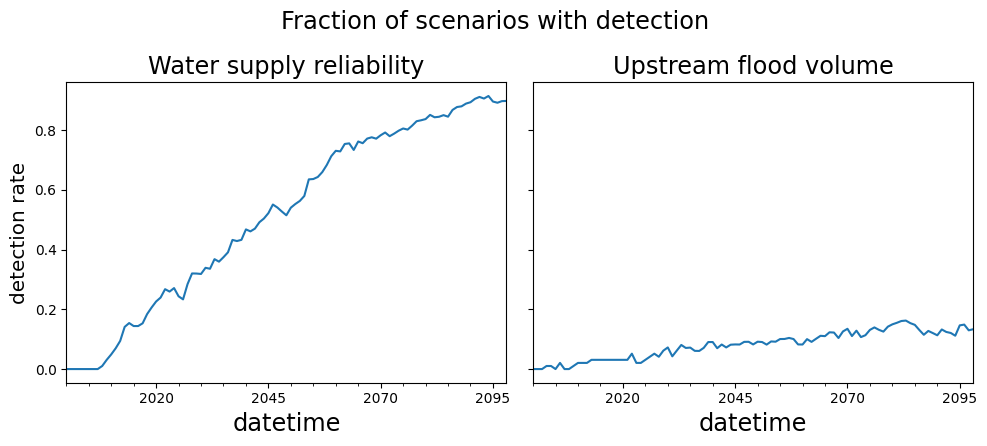

<Figure size 640x480 with 0 Axes>

In [10]:
plot_multi_total()

### 2. With pre-whitening

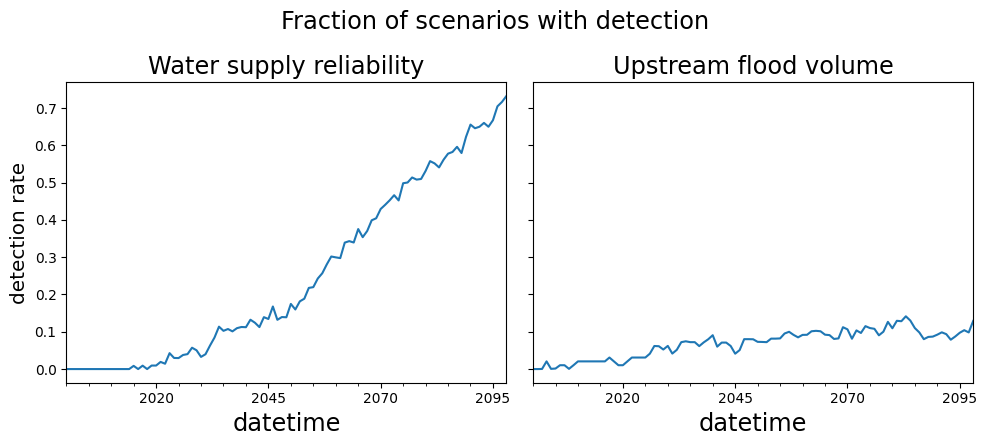

<Figure size 640x480 with 0 Axes>

In [11]:
plot_multi_total(pre_whitening=True)